In [4]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from stable_baselines3 import PPO, TD3
import time
import gymnasium as gym


plt.rcParams["figure.figsize"] = (10, 5)

In [20]:
# Create and wrap the environment
env_train_1 = gym.make("Humanoid-v4", render_mode="human", healthy_reward = 10, forward_reward_weight = 0.625,  healthy_z_range=(0.75,2.0))
env_train_2 = gym.make("Humanoid-v4",render_mode="human", healthy_reward = 2.5, forward_reward_weight = 2.5, healthy_z_range=(0.75,2.0))
env_test = gym.make("Humanoid-v4", render_mode = "human", healthy_z_range=(0.75,2.0))
#env = gym.make("Humanoid-v4", forward_reward_weight = 5, healthy_reward = 20)
wrapped_env_train_1 = gym.wrappers.RecordEpisodeStatistics(env_train_1)  # Records episode-reward
wrapped_env_train_2 = gym.wrappers.RecordEpisodeStatistics(env_train_2)
wrapped_env_test = gym.wrappers.RecordEpisodeStatistics(env_test)

rewards_over_seeds = []



#for seed in [1, 2, 3, 5, 8, 13, 21]:  # Fibonacci seeds
for seed in [1,2]:
    steps_in_seed = 0

    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    agent = PPO('MlpPolicy', wrapped_env_train_1, verbose=1, tensorboard_log="\\logs")
    agent.learn(total_timesteps=1000,progress_bar=True, tb_log_name="PPO_1_"+str(seed), reset_num_timesteps=False)
    agent.save("agent_1")
    del agent
    env_train_1.close()
    agent = PPO.load("agent_1", env = wrapped_env_train_2)
    agent.learn(total_timesteps=1000,progress_bar=True, tb_log_name="PPO_2_"+str(seed), reset_num_timesteps=False)
    agent.save("agent_2")
    del agent
    env_train_2.close()
    agent = PPO.load("agent_2", env = wrapped_env_test)
    reward_over_episodes = []


    for episode in range(10):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env_test.reset(seed=seed)

        done = False


        while not done:
            action, _states = agent.predict(obs)
            obs, reward, terminated, truncated, info = wrapped_env_test.step(action)
            done = terminated or truncated
            wrapped_env_test.render()
        
        reward_over_episodes.append(wrapped_env_test.return_queue[-1][0])
        if (episode+1) % 10 == 0:
            avg_reward = int(np.mean(reward_over_episodes[-10:]))
            print("Episode:", episode+1, "Average Reward:", avg_reward)
            print("Current total no. steps: ", steps_in_seed)
    
    rewards_over_seeds.append(reward_over_episodes)
    env_test.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to \logs\PPO_1_1_0


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.9     |
|    ep_rew_mean     | 361      |
| time/              |          |
|    fps             | 197      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 2048     |
---------------------------------


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to \logs\PPO_1_1_0


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.9     |
|    ep_rew_mean     | 192      |
| time/              |          |
|    fps             | 211      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 4096     |
---------------------------------


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode: 10 Average Reward: 204
Current total no. steps:  0
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to \logs\PPO_1_2_0


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.4     |
|    ep_rew_mean     | 328      |
| time/              |          |
|    fps             | 316      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to \logs\PPO_1_2_0


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.1     |
|    ep_rew_mean     | 207      |
| time/              |          |
|    fps             | 280      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 4096     |
---------------------------------


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode: 10 Average Reward: 154
Current total no. steps:  0


In [16]:
reward_over_episodes[0]

156.26595

In [18]:
rewards_over_seeds[0]

[205.07503,
 269.2196,
 264.98798,
 196.1278,
 120.74056,
 148.42848,
 252.32835,
 133.11496,
 183.8221,
 250.68037]

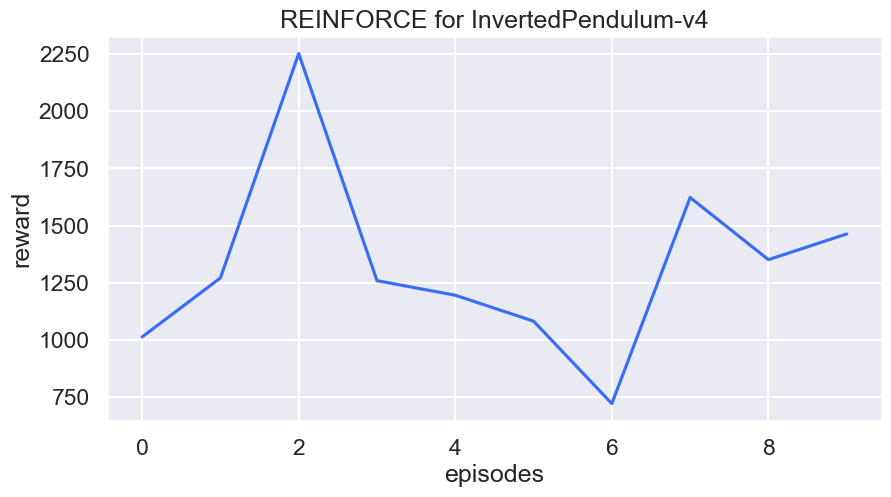

In [4]:
rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for InvertedPendulum-v4"
)
plt.show()

In [2]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('rewards_plot', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(rewards_to_plot, f)

with open('rewards_over_seeds', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(rewards_over_seeds, f)

torch.save(agent, 'agent')

NameError: name 'rewards_to_plot' is not defined

In [4]:
# Create and wrap the environment
env = gym.make("Humanoid-v4", render_mode = "human")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

total_num_episodes = int(5e3)  # Total number of episodes
# Observation-space of InvertedPendulum-v4 (4)
obs_space_dims = env.observation_space.shape[0]
# Action-space of InvertedPendulum-v4 (1)
action_space_dims = env.action_space.shape[0]
rewards_over_seeds = []
total_steps = 0

for seed in [1]:  # Fibonacci seeds

    steps_in_seed = 0

    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    #agent = torch.load('agent2')
    reward_over_episodes = []

    for episode in range(10):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False

        steps = 0

        while not done:
            steps+=1
            action, _states = agent.predict(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            #agent.rewards.append(reward)
            

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of times
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated
        
        steps_in_seed+=steps
        reward_over_episodes.append(wrapped_env.return_queue[-1])
        #agent.update()

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)
            print("Current total no. steps: ", steps_in_seed)
    
    total_steps+=steps_in_seed
    rewards_over_seeds.append(reward_over_episodes)

    print("total no. steps: ", total_steps)


Episode: 0 Average Reward: 473
Current total no. steps:  91
total no. steps:  684


: 